In [2]:
import dotenv
dotenv.load_dotenv()

from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

llm = init_chat_model("openai:gpt-4o-mini")

conn = sqlite3.connect(
    "chat.db",
    check_same_thread=False,
)

config = {
    "configurable": {
        "thread_id": "O_X",
    }
}


In [56]:
class State(MessagesState):
    pass


graph_builder = StateGraph(State)


In [57]:
from langchain_core.tools import tool
from langgraph.types import interrupt


@tool
def get_human_feedback(poem: str):
    """
    Ask the user for feedback on the poem.
    Use this before returning the final response.
    """
    feedback = interrupt(f"Here is the poem, tell me what you think \n {poem}")
    return feedback


llm_with_tool = llm.bind_tools(tools=[get_human_feedback])


def chatbot(chatbot_state: State):
    response = llm_with_tool.invoke(
        f"""

        You are an expert in making poems.
        Use the `get_human_feedback` tool to get feedback on your poem.

        Only after you receive positive feedback you can return the final poem.
        Always ask for FeedBACK FIRST.
        Here is the confersation history :

        {chatbot_state["messages"]}
        """
                                    )
    return {"messages": [response]}




In [58]:

tool_node = ToolNode(
    tools=[get_human_feedback]
)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")

graph = graph_builder.compile(
    checkpointer=SqliteSaver(conn)
)


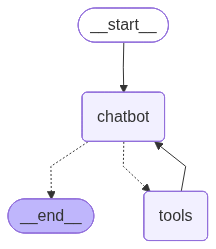

In [59]:
display(graph)


In [60]:

result1 = graph.invoke(
    {
        "messages": [{
            "role": "user",
            "content": "Please make a poem about Python code."
        }]
    },
    config=config
)



{'messages': [HumanMessage(content='Please make a poem about Python code.', additional_kwargs={}, response_metadata={}, id='60821dc7-6c1d-42a5-bf48-d4b7ecc917f7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7NbMrumhpfXmWMazIH8wLm5X', 'function': {'arguments': '{"poem":"In the realm of logic, where ideas flow,\\nA serpentine syntax begins to glow.\\nPython code dances, sleek and bright,\\nCrafting solutions with elegant light.\\n\\nVariables whisper in dynamic cheer,\\nLoops spin stories, both far and near.\\nFunctions beckon with purpose and grace,\\nIn every indentation, a world to embrace.\\n\\nImporting libraries like treasures untold,\\nFrom NumPy to Pandas, their wonders unfold.\\nDebugging the journey, with care and with wit,\\nEach colon and bracket a puzzle well-fit.\\n\\nA community thrives, where coders unite,\\nSharing their knowledge, igniting the light.\\nIn Python we trust, our favorite tool,\\nA language so powerful, yet splendidly cool."}', '

In [63]:
from langgraph.types import Command

response = Command(resume="It looks great!")

result = graph.invoke(
    response,
    config=config,
)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Please make a poem about Python code.
================================== Ai Message ==================================
Tool Calls:
  get_human_feedback (call_7NbMrumhpfXmWMazIH8wLm5X)
 Call ID: call_7NbMrumhpfXmWMazIH8wLm5X
  Args:
    poem: In the realm of logic, where ideas flow,
A serpentine syntax begins to glow.
Python code dances, sleek and bright,
Crafting solutions with elegant light.

Variables whisper in dynamic cheer,
Loops spin stories, both far and near.
Functions beckon with purpose and grace,
In every indentation, a world to embrace.

Importing libraries like treasures untold,
From NumPy to Pandas, their wonders unfold.
Debugging the journey, with care and with wit,
Each colon and bracket a puzzle well-fit.

A community thrives, where coders unite,
Sharing their knowledge, igniting the light.
In Python we trust, our favorite tool,
A language so powerful, yet splendidly cool.
===============

In [62]:

"""

for state in graph.get_state_history(
    {
        "configurable": {
            "thread_id": "2",
        },
    }
):
    print(state)

# Stream 모드는 데이터베이스 연동을 다르게 해야 함.
async for event in graph.astream(
    {
        "messages": [
            {
                "role": "user",
                "content": "what is the weather in berlin, budapest and bratislava.",
            },
        ]
    },
    stream_mode="updates",
    # config={
    #     "configurable": {
    #         "thread_id": "2",
    #     },
    # },
):
    print(event)

"""

'\n\nfor state in graph.get_state_history(\n    {\n        "configurable": {\n            "thread_id": "2",\n        },\n    }\n):\n    print(state)\n\n# Stream 모드는 데이터베이스 연동을 다르게 해야 함.\nasync for event in graph.astream(\n    {\n        "messages": [\n            {\n                "role": "user",\n                "content": "what is the weather in berlin, budapest and bratislava.",\n            },\n        ]\n    },\n    stream_mode="updates",\n    # config={\n    #     "configurable": {\n    #         "thread_id": "2",\n    #     },\n    # },\n):\n    print(event)\n\n'